In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta

In [2]:
cmap = plt.get_cmap("tab10", 10)
sns.set_style("whitegrid")

In [3]:
class Environment:
    def __init__(self, variants, payouts, n_trials, variance=False):
        self.variants = variants
        if variance:
            self.payouts = np.clip(payouts + np.random.normal(0, 0.04, size=len(variants)), 0, .2)
        else:
            self.payouts = payouts
        #self.payouts[5] = self.payouts[5] if i < n_trials/2 else 0.1
        self.n_trials = n_trials
        self.total_reward = 0
        self.n_k = len(variants)
        self.shape = (self.n_k, n_trials)
        
    def run(self, agent):
        """Run the simulation with the agent. 
        agent must be a class with choose_k and update methods."""
        
        for i in range(self.n_trials):
            # agent makes a choice
            x_chosen = agent.choose_k()
            # Environment returns reward
            reward = np.random.binomial(1, p=self.payouts[x_chosen])
            # agent learns of reward
            agent.reward = reward
            # agent updates parameters based on the data
            agent.update()
            self.total_reward += reward
        
        agent.collect_data()
        
        return self.total_reward

In [4]:
class BaseSampler:
    
    def __init__(self, env, n_samples=None, n_learning=None, e=0.05, c=None):
        self.env = env
        self.shape = (env.n_k, n_samples)
        self.variants = env.variants
        self.n_trials = env.n_trials
        self.payouts = env.payouts
        self.ad_i = np.zeros(env.n_trials)
        self.r_i = np.zeros(env.n_trials)
        self.thetas = np.zeros(self.n_trials)
        self.regret_i = np.zeros(env.n_trials)
        self.thetaregret = np.zeros(self.n_trials)
        
        self.a = np.ones(env.n_k) 
        self.b = np.ones(env.n_k) 
        self.theta = np.zeros(env.n_k)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.k = 0
        self.i = 0
        
        self.n_samples = n_samples
        self.n_learning = n_learning
        self.e = e
        self.c = c
        self.ep = np.random.uniform(0, 1, size=env.n_trials)
        self.exploit = (1 - e)
        self.timestamp = 1
        
    def collect_data(self):
        
        self.data = pd.DataFrame(dict(ad=self.ad_i, reward=self.r_i, regret=self.regret_i))

In [5]:
class RandomSampler(BaseSampler):
    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        
        self.k = np.random.choice(self.variants)
        
        return self.k
    
    def update(self):
        # nothing to update
        self.thetaregret[self.i] = np.max(self.theta) - self.theta[self.k]
        
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [6]:
class eGreedy(BaseSampler):

    def __init__(self, env, n_learning, e):
        super().__init__(env, n_learning, e)
        self.n_learning = n_learning
        self.e = e
        
    def choose_k(self):

        # e% of the time take a random draw from machines
        # random k for n learning trials, then the machine with highest theta
        self.k = np.random.choice(self.variants) if self.i < self.n_learning else np.argmax(self.theta)
        # with 1 - e probability take a random sample (explore) otherwise exploit
        self.k = np.random.choice(self.variants) if self.ep[self.i] > self.exploit else self.k
        return self.k

    def update(self):
        
        # update the probability of payout for each machine
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]
 
        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [7]:
class upper_confidence_bounds(BaseSampler):
    
    def __init__(self, env, c):
        super().__init__(env, c)
        self.c = c
        
    def choose_k(self):
        
        self.k = np.argmax(self.theta + self.c * np.sqrt(np.log(self.timestamp) / self.b))
        
        return self.k
    
    def update(self):
        
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b
        self.timestamp += 1
        
        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]
 
        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [8]:
variants = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
payouts = [0.023, 0.03, 0.029, 0.001, 0.05, 0.06, 0.0234, 0.035, 0.01, 0.11]
n_trails = 100000

In [9]:
en0 = Environment(variants, payouts, n_trails)
rs = RandomSampler(en0)
rs_total_score = en0.run(agent=rs)

en1 = Environment(variants, payouts, n_trails)
eg = eGreedy(en0, 100, .2)
eg_total_score = en1.run(agent=eg)

en2 = Environment(variants, payouts, n_trails)
ucb = upper_confidence_bounds(en0, 0.03)
ucb_total_score = en2.run(agent=ucb)

In [10]:
def plot_k_choices(agent, title, total):
    plt.figure(figsize=(20,10))
    x = np.arange(0, agent.n_trials)
    plt.scatter(x, agent.ad_i, cmap=cmap, c=agent.ad_i, marker=".", alpha=1)
    plt.title('{} total:{}'.format(title, total), fontsize=16, fontweight="bold")
    plt.xlabel("Trial", fontsize=16, fontweight="bold")
    plt.ylabel("Variant", fontsize=16, fontweight="bold")
    plt.yticks(list(range(10)))
    plt.colorbar();


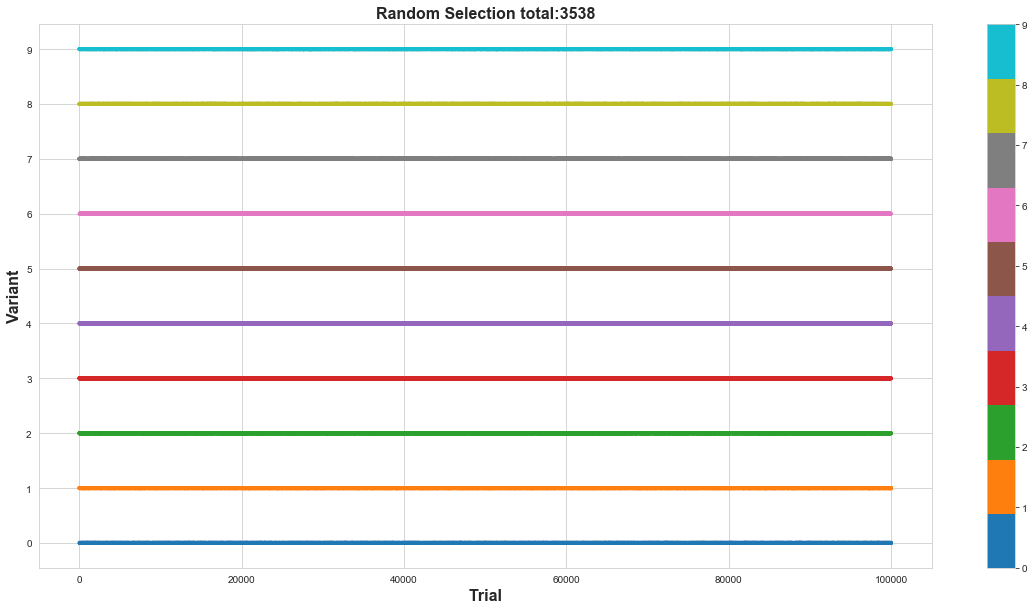

In [11]:
plot_k_choices(rs, "Random Selection", rs_total_score)

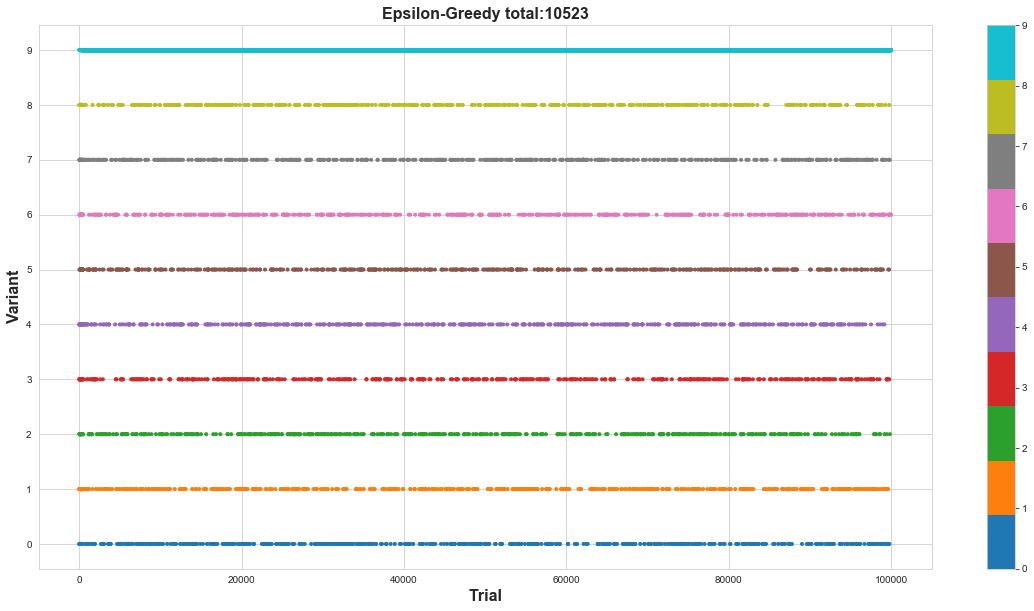

In [12]:
plot_k_choices(eg, "Epsilon-Greedy", eg_total_score)

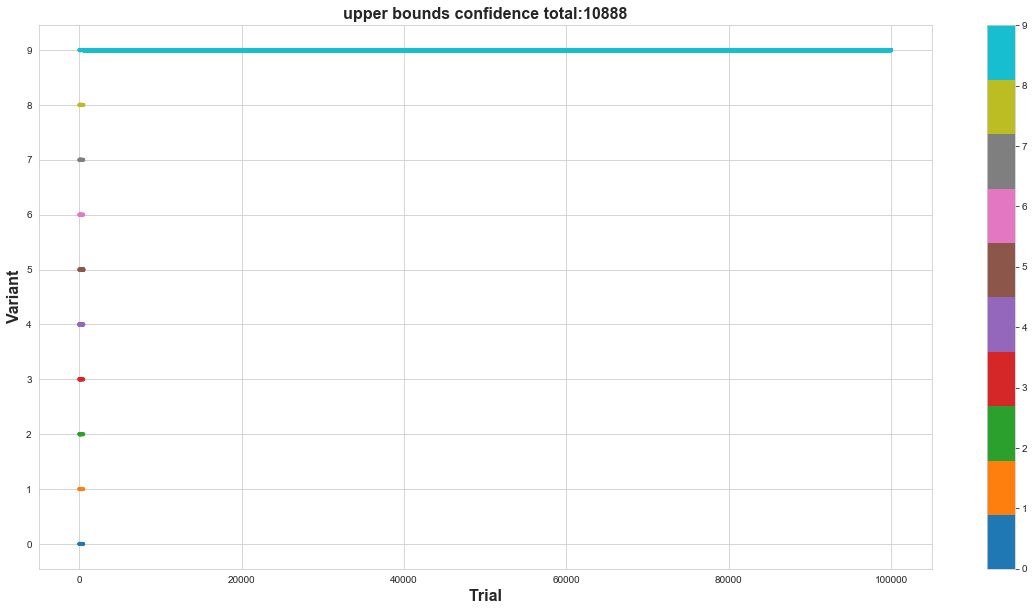

In [13]:
plot_k_choices(ucb, "upper bounds confidence", ucb_total_score)

In [14]:
totals = {'rs':[], 'eg':[], 'ucb':[]}
for _ in range(100):
    en0 = Environment(variants, payouts, n_trails)
    rs = RandomSampler(en0)
    totals['rs'].append(en0.run(agent=rs))

    en1 = Environment(variants, payouts, n_trails)
    eg = eGreedy(en0, 100, .2)
    totals['eg'].append(en1.run(agent=eg))

    en2 = Environment(variants, payouts, n_trails)
    ucb = upper_confidence_bounds(en0, 0.03)
    totals['ucb'].append(en2.run(agent=ucb))

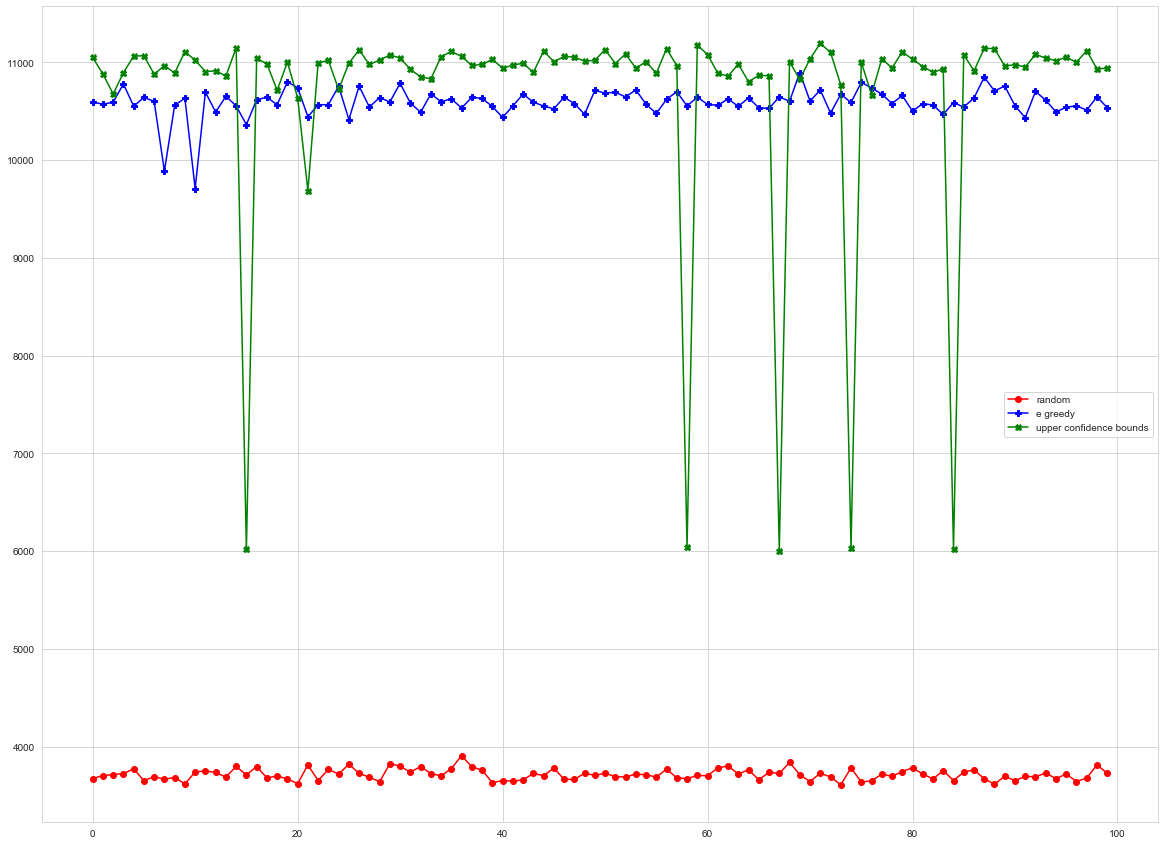

In [15]:
plt.figure(figsize=(20,15))
x = np.arange(0,100)
plt.plot(x, totals['rs'],c='r', linestyle='-', marker='o', label='random')
plt.plot(x, totals['eg'],c='b', linestyle='-', marker='P', label='e greedy')
plt.plot(x, totals['ucb'],c='g', linestyle='-', marker='X', label='upper confidence bounds')
plt.legend();

<BarContainer object of 3 artists>

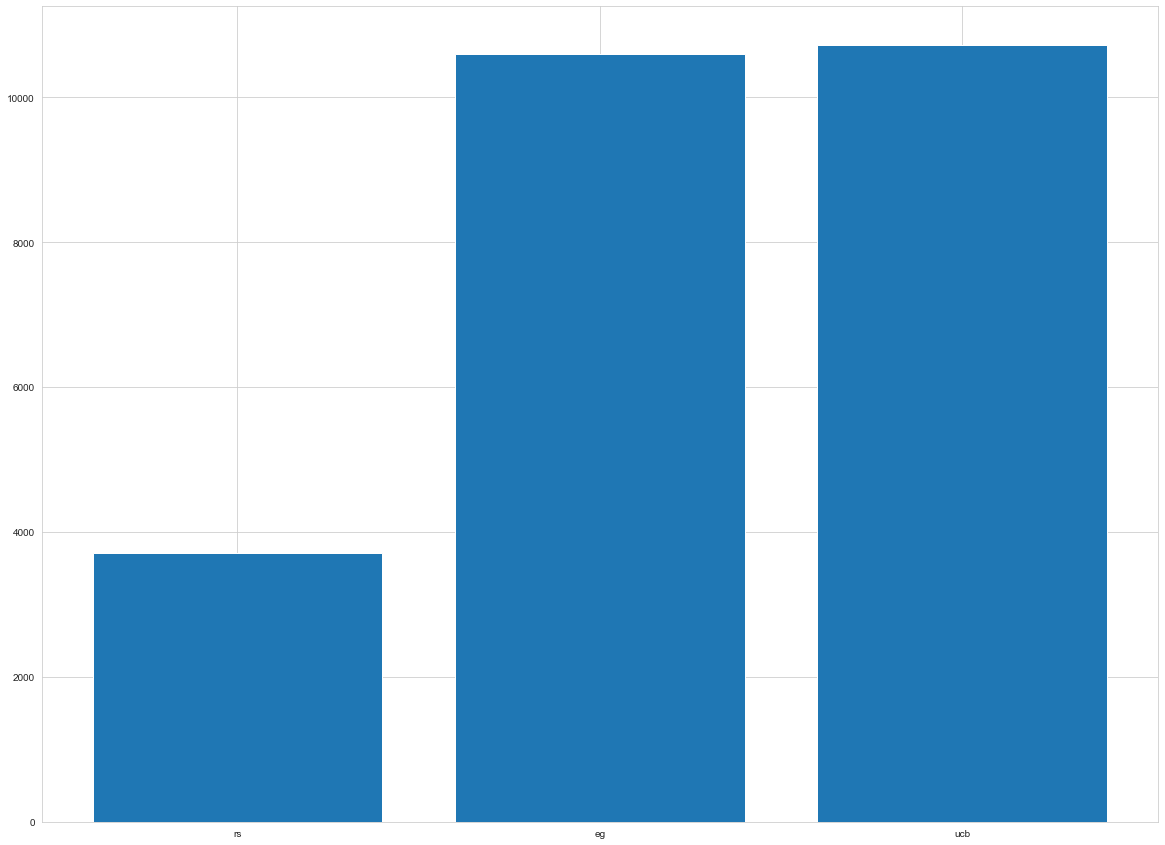

In [16]:
plt.figure(figsize=(20,15))
plt.bar(['rs', 'eg', 'ucb'],  [np.array(totals['rs']).mean(),
np.array(totals['eg']).mean(),
np.array(totals['ucb']).mean()])

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\User\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


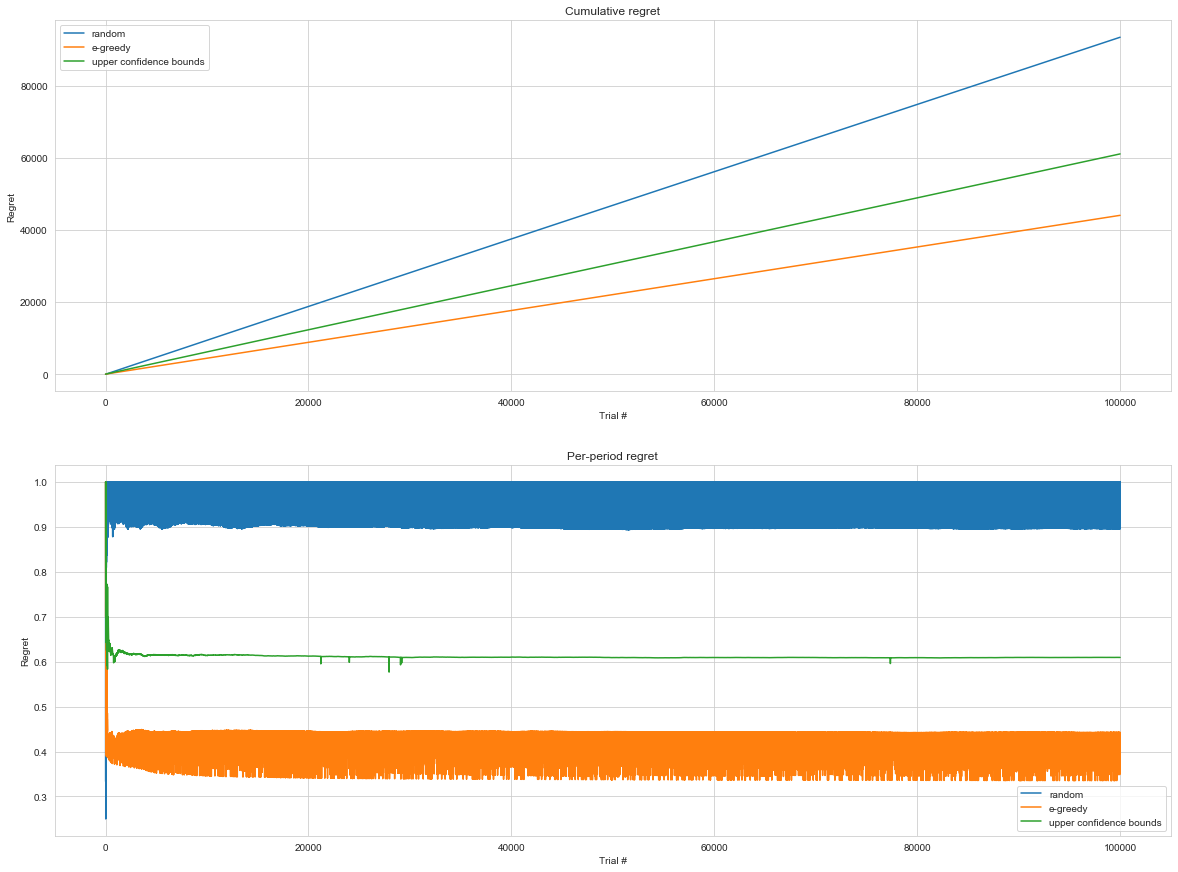

In [17]:
plt.figure(figsize=(20,15))

plt.subplot(211)
plt.plot(np.cumsum(1 - rs.thetaregret), label="random")
plt.plot(np.cumsum(1 - eg.thetaregret), label="e-greedy")
plt.plot(np.cumsum(1 - ucb.thetaregret), label="upper confidence bounds")
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Cumulative regret")
plt.legend();

plt.subplot(212)
plt.plot(1 - rs.thetaregret, label="random")
plt.plot(1 - eg.thetaregret, label="e-greedy")
plt.plot(1 - ucb.thetaregret, label="upper confidence bounds")
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Per-period regret")
plt.legend();